In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**IMPORTANT NOTE**: This handout notebook relies on functions from the **for-this-class-only** `mylib` package. To access this package, clone or download it from **[this GitHub page](https://github.com/aalgahmi/mylib)**. You can find instructions on how to clone this package on its main GitHub page, as well as in the `04.working_with_datasets.ipynb` notebook handout. Make sure to place the `mylib` folder from this package in the same directory as this notebook. Once you've completed this step, the following import should work seamlessly.

In [2]:
import mylib as my

# 10: Linear models

## Linear regression
Here we have $n$ examples each with $m$ features. For a single example $(\mathbf{x}, y)$ The linear regression model is written as:
$$h(\mathbf{x}) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_m x_m$$
where $w_0, w_1, \cdots, w_m$ are the weight parameters we are trying to learn. 

NOTE: In the multidimensional case, we have a regression hyperplane instead of a regression line. 

We can express this model for a single example using the matrix notation like this:

$$h(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$$

For the entire training dataset, we have:
$$h(\mathbf{X}) = \mathbf{X} \mathbf{w}$$


### Using the normal equation
Using the $L_2$ loss function which is defined as:

$$L_2 = \frac{1}{2} \sum_{i=1}^n (y^{(i)} - h(\mathbf{x}^{(i)}))^2 = \frac{1}{2} \sum_{i=1}^n (y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)})^2$$
     
or in matrix notation as:
    $$L_2 = \frac{1}{2} (\mathbf{y} - h(\mathbf{X}))^T(\mathbf{y} - h(\mathbf{X})) = \frac{1}{2} (\mathbf{y} - \mathbf{X} \mathbf{w})^T(\mathbf{y} - \mathbf{X} \mathbf{w})$$

We can use the following equation to find the weight parameters $\mathbf{w}$ that minimize the loss equation $L_2$:

$$ \mathbf{w}  = (\mathbf{X}^T \mathbf{X} )^{-1} \mathbf{X}^T \mathbf{y}$$


In [3]:
class LinearRegressor:
    def fit(self, X, y):
        X = np.concatenate([np.ones((len(X), 1)), X], axis=1)
        self.w = np.dot(np.linalg.pinv(X), y)
        
        return self

    def score(self, X, y):
        ss_res = np.sum((y - self.predict(X))**2)
        ss_tot = np.sum((y - y.mean())**2)
        return 1 - ss_res / ss_tot
    
    def predict(self, X_unseen):
        return np.dot(np.concatenate([np.ones((len(X_unseen), 1)), X_unseen], axis=1), self.w).squeeze()

Let's test it and compare its performance to that of SciKit Learn. First we create a sample dataset:

In [4]:
X = np.arange(0, 15, .1).reshape(-1, 1)
y = (2 * X + 2 + np.random.normal(loc=2, scale=4, size=(len(X),1))).squeeze()

X.shape, y.shape

((150, 1), (150,))

Let's plot this data:

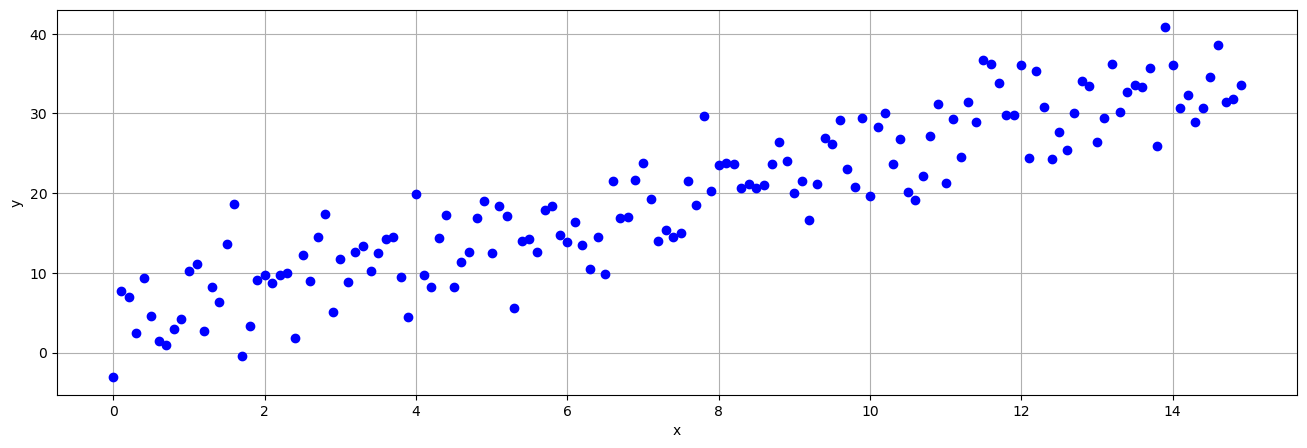

In [5]:
# plottong
fig = plt.figure(figsize=(16,5))
plt.plot(X, y, 'bo')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

Next we create two models: one using the above implementation and another using SciKit Learn's `sklearn.linear_model.LinearRegression` class. 

In [6]:
from sklearn.linear_model import LinearRegression

scratch_lg = LinearRegressor().fit(X, y)
sklearn_lg = LinearRegression().fit(X, y)

results = pd.DataFrame({
    "scratch_model": { "Intercept": scratch_lg.w[0], "Slope": scratch_lg.w[1] , "$R^2$ score": scratch_lg.score(X, y) },
    "sklearn_model": { "Intercept": sklearn_lg.intercept_, "Slope": sklearn_lg.coef_[0], "$R^2$ score": sklearn_lg.score(X, y) }
})

results

,scratch_model,sklearn_model
Intercept,3.933735,3.933735
Slope,2.092440,2.092440
$R^2$ score,0.834349,0.834349


And here is the regression line:

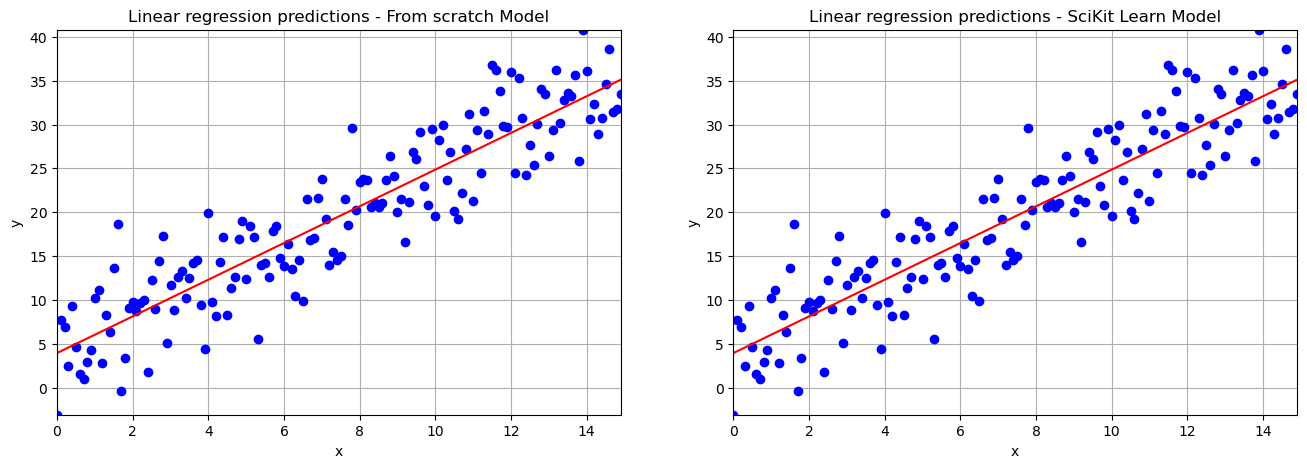

In [7]:
fig = plt.figure(figsize=(16,5))
models = { "From scratch Model": scratch_lg, "SciKit Learn Model": sklearn_lg }
for i , (title, model) in enumerate(models.items()):
    plt.subplot(1, 2, i + 1)
    plt.plot(X, y, 'bo')
    input = np.array([[X.min()], [X.max()]])
    output = model.predict(input)
    plt.plot(input, output, 'r-')
    plt.axis([*input, y.min(), y.max()])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.title(f"Linear regression predictions - {title}")

### Using gradient descent
Given a loss function $L(\mathbf{w})$, we can try to find $\mathbf{w}$ that minimizes the loss function using gradient descent:

$$\mathbf{w} = \mathbf{w} - \eta \nabla L(\mathbf{w})$$

where $\eta$ is the learning rate and $\nabla L(\mathbf{w})$ is the gradient (a vector of partial derivatives one for each $w_i$).

For a single weight $w_i$ given a single example $(\mathbf{x}, y)$.

$$w_i = w_i - \eta \frac{\delta L(\mathbf{w})}{\delta w_i}$$
If $L$ is $L_2$ then:
$$w_i = w_i - \eta \frac{\delta\ \ \frac{1}{2}(y - \mathbf{w}^T \mathbf{x})^2}{\delta w_i}$$

which gives us the update rule:
$$w_i = w_i + \eta (y - \mathbf{w}^T \mathbf{x}) x_i$$

Using **gradient descent** we can find optimal or near optimal values for these parameters using the following iterative five-step algorithm. 

* **STEP 1**: Initialize the parameters $w_0, \cdots, w_m$
* Inside the training loop:
    * **STEP 2**: Calculate the predicted output 
    * **STEP 3**: Calculate the loss function. Using the $L_2$ function, this would be: $$L_2 = \frac{1}{2}(y_{actual} - y_{predicted})^2$$
    * **STEP 4**: Calculate the gradients of the loss function with respect to the $b$ and $w_1, \cdots, w_m$ parameters.
    * **STEP 5**: Update the values of the $w_0, \cdots, w_m$ parameters using the gradient descent update rules:
        $$w_i = w_i - \eta (y_{actual} - y_{predicted}) x_i$$
        where $\eta$ is the learning rate.
Every iteration over the training dataset is called **an epoch**. Here is a class implementing these steps.

In [8]:
class GDLinearRegressor:
    def __init__(self, eta=.0001, epochs=10, random_state=17):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
    
    def fit(self, X, y):
        X = np.concatenate([np.ones((len(X), 1)), X], axis=1)
        y = y.reshape(len(X), -1) if y.ndim == 1 else y
        n = X.shape[0]
        m = X.shape[1]
        
        # STEP 1: Initialize the weight parameters
        rgen = np.random.RandomState(self.random_state)
        self.w = rgen.normal(loc=0.0, scale=0.01, size=m).reshape(m, 1)
        
        self.hist = {'losses': [], 'scores': []}
        for e in range(self.epochs): 
            # STEP 2: Calculate the predicted output
            predicted = np.dot(X, self.w)
            
            # STEP 3: Calculate the loss function
            error = y - predicted
            loss = (1/n) * np.dot(error.T, error) # dividing by n to scale the cost down
            self.hist['losses'].append(loss[0, 0] / n) 
            
            # STEP 4: Calculate the gradient of the loss function with respect to the weights
            gradient = np.dot(X.T, error)
            
            # STEP 5: Update the weights
            self.w = self.w + self.eta * gradient
            
            self.hist['scores'].append(self.score(X[:, 1:], y.squeeze()))
            
        return self
    
    def score(self, X, y):
        ss_res = np.sum((y - self.predict(X))**2)
        ss_tot = np.sum((y - y.mean())**2)
        return 1 - ss_res / ss_tot
        
    def predict(self, X_unseen):
        return np.dot(np.concatenate([np.ones((len(X_unseen), 1)), X_unseen], axis=1), self.w).squeeze()

Let's test it using the same dataset as above and print its $R^2$ score:

In [9]:
gd = GDLinearRegressor().fit(X, y)

pd.DataFrame({
    "Intercept": gd.w[0],
    "Slope": gd.w[1],
    "$R^2$ score": gd.score(X, y) })

,Intercept,Slope,$R^2$ score
0,0.388319,2.449369,0.802087


For every training epoch, the above class keeps a history of the losses and scores. We can use that to plot the learning curves. 

<AxesSubplot: title={'center': 'Training losses and scores'}, xlabel='Epochs'>

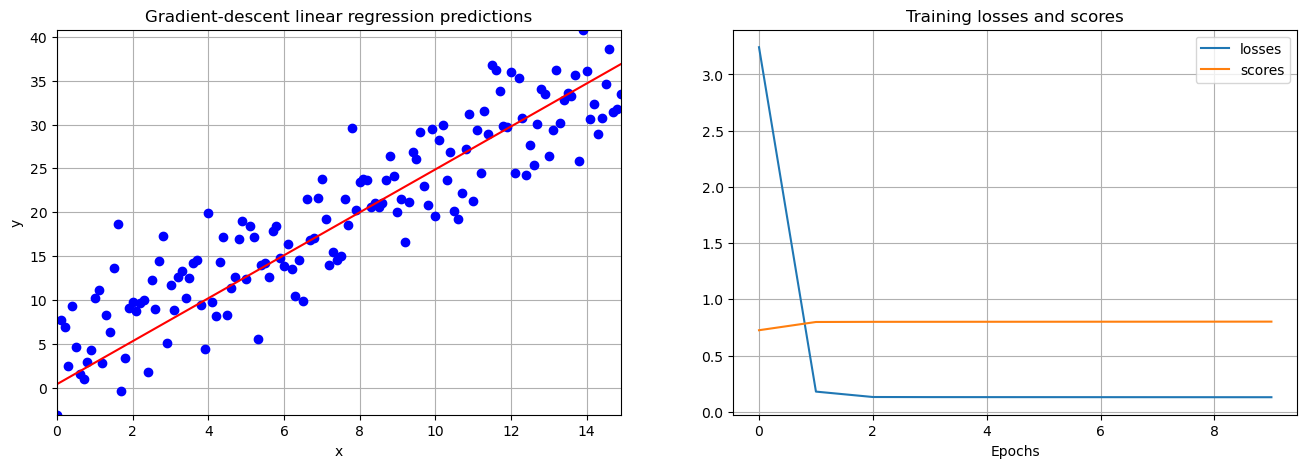

In [10]:
fig = plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(X, y, 'bo')

input = np.array([[X.min()], [X.max()]])
output = gd.predict(input)
plt.plot(input, output, 'r-')
plt.axis([*input, y.min(), y.max()])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title("Gradient-descent linear regression predictions")

ax = plt.subplot(1, 2, 2)
pd.DataFrame(gd.hist).plot(ax=ax, grid=True, xlabel="Epochs", title="Training losses and scores")

### Changing epochs and $\eta$
And we can even plot the regression lines after various numbers of epochs (an epoch is a one pass over the entire training dataset). 

When the learning rate $\eta$ is just about right, the convergence happens quickly.

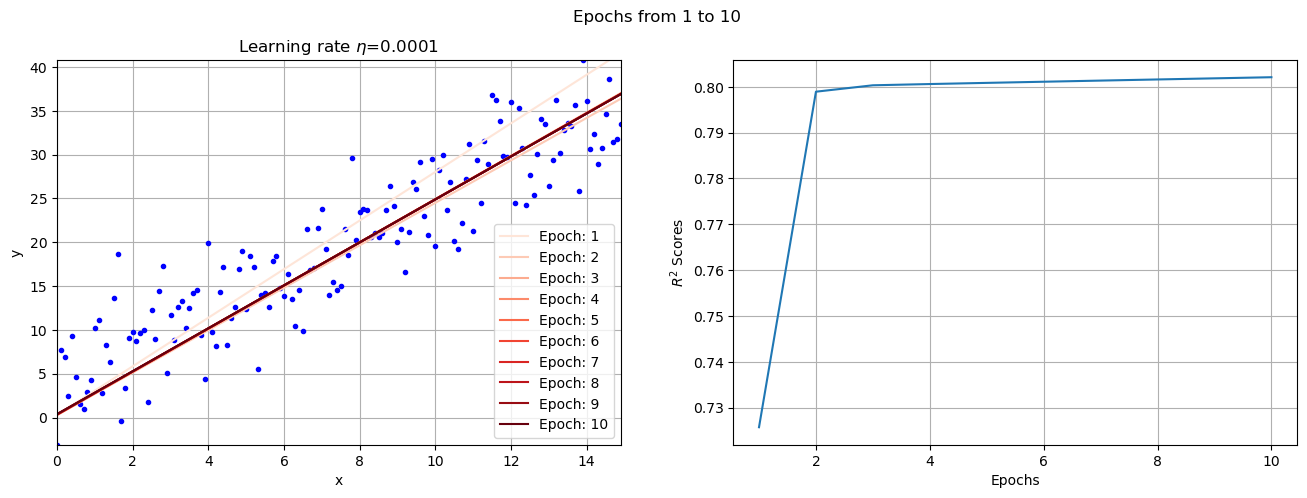

In [11]:
import matplotlib as mpl

def plot_regression_lines(x, y, eta, epochs=20):
    fig = plt.figure(figsize=(16,5))
    fig.suptitle(f'Epochs from {1} to {epochs}')
    plt.subplot(1,2,1)
    plt.plot(x, y, 'b.')
    n_shown = 10
    scores = []
    for e in range(1, epochs + 1):
        gd = GDLinearRegressor(eta=eta, epochs=e).fit(x, y)
        input = np.array([x.min(), x.max()])
        output = gd.predict(input.reshape(-1, 1))
        if e % (epochs // n_shown) == 0:
            c = mpl.colors.rgb2hex(plt.cm.Reds(e / n_shown))

            plt.plot(input, output, color=c, label= f"Epoch: {e}")
            plt.axis([x.min(), x.max(), y.min(), y.max()])
            
        scores.append(gd.score(x, y))

    plt.title(f'Learning rate $\eta$={eta}')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
                      
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), scores)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('$R^2$ Scores')
    
plot_regression_lines(X, y, 0.0001, epochs=10)

When the learning rate $\eta$ is small, the convergence takes more epochs.

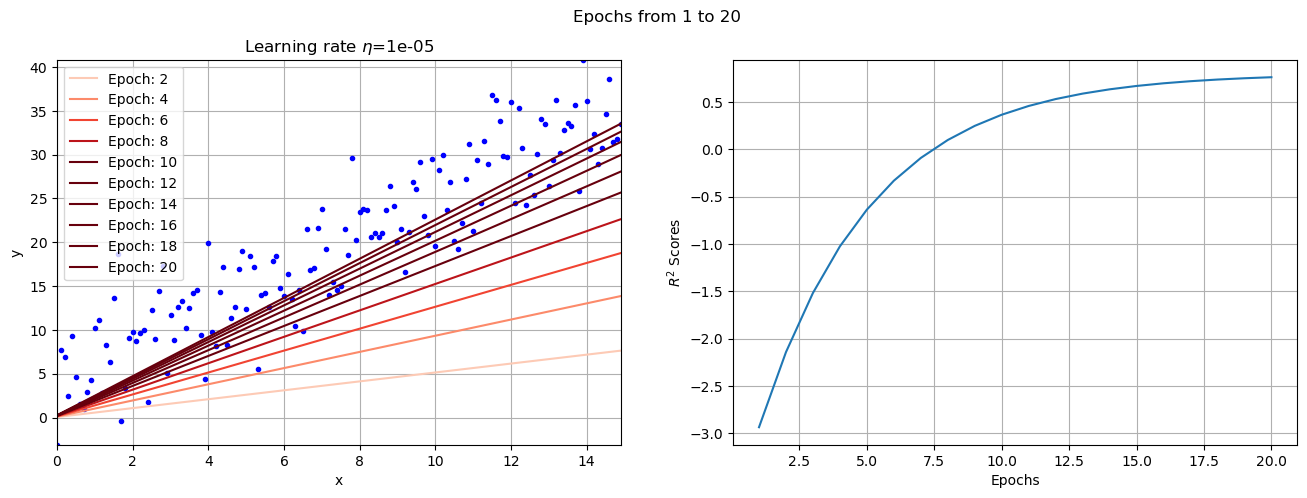

In [12]:
plot_regression_lines(X, y, 0.00001, epochs=20)

And here is it when the learning rate $\eta$ is too large. This shows a model the does not converge.

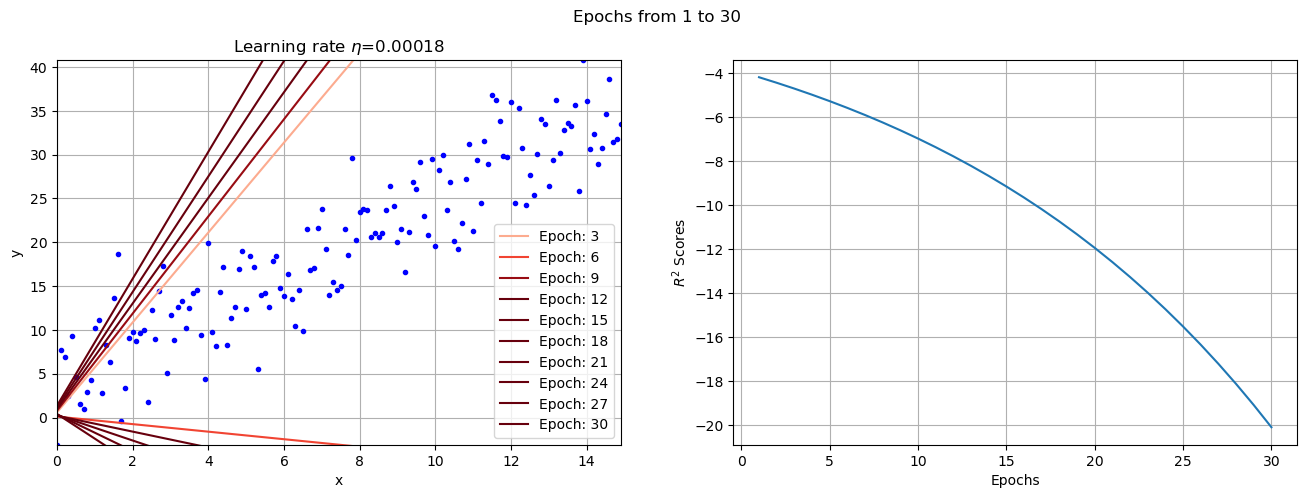

In [13]:
plot_regression_lines(X, y, 0.00018, epochs=30)

In [14]:
# TODO

## Polynomial regression
Linear models are "linear" with respect to the weights and not the input features of $\mathbf{X}$. That means the input features can non-linear. Let's see an example.

Let's generate some random non-linear data.

Text(0.5, 1.0, 'Orignal non-linear data')

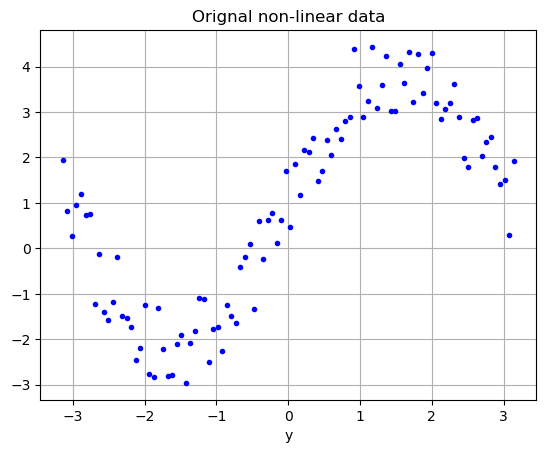

In [15]:
N = 100
X = np.linspace(-np.pi, np.pi, N)
y = 3 * np.sin(X) + 2 * np.random.rand(N)
X = X.reshape(-1, 1)

plt.plot(X, y, "b.")
plt.xlabel('x')
plt.xlabel('y')
plt.grid()
plt.title("Orignal non-linear data")

Obviously a simple linear regression is not a good fit. A better alternative would be to fit a polynomial curve of degree $n$ to this data. This curve will take the form:

$$w_{n}x^{n}+w_{n-1}x^{n-1}+\dotsb +w_{2}x^{2}+w_{1}x + w_{0} = 0$$

We can use SciKit Learn's `PolynomialFeatures` that takes the original input feature and generate the $n$ polynomial terms of the equation above. This translates our input data from a one-feature input to $n$-feature input data. We then train a multiple linear regression on this new data.

Here is how we can fit a third-degree polynomial curve to this data.

Weights: [ 2.58321811  0.02096374 -0.28347557]
Score: 0.9280937778082994


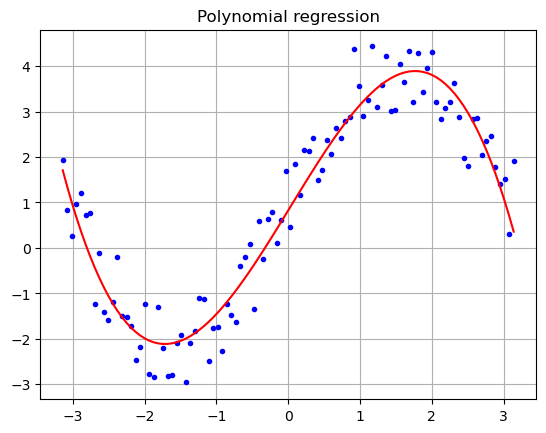

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X.reshape(-1, 1))

model = LinearRegression().fit(poly_features, y)

plt.plot(X, y, "b.")
plt.plot(X, model.predict(poly_features), 'r-')
plt.grid()
plt.title("Polynomial regression")
print("Weights:", model.coef_)
print("Score:", model.score(poly_features, y))

This is a good fit. Let's try different degree values.

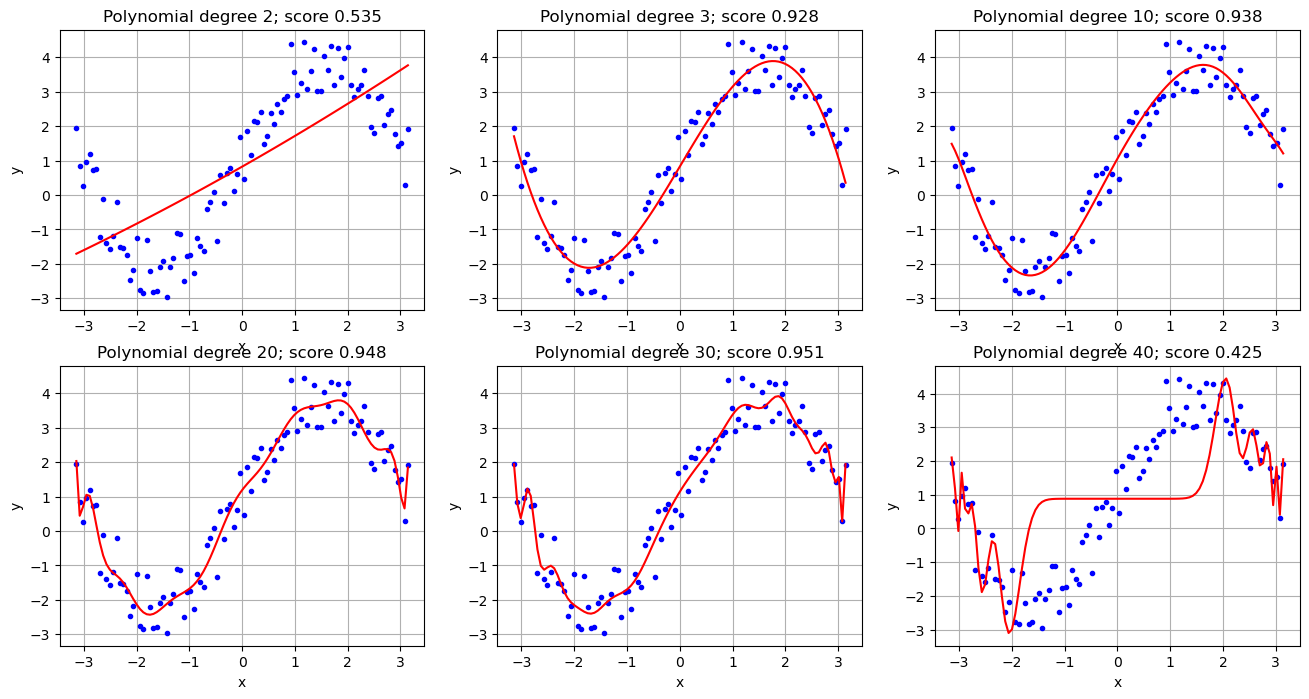

In [17]:
degrees = [2, 3, 10, 20, 30, 40]
fig = plt.figure(figsize=(16, 8))
for i, n in enumerate(degrees):
    poly = PolynomialFeatures(degree=n, include_bias=False)

    poly_features = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(poly_features, y)
    
    plt.subplot(2, 3, i + 1)
    plt.plot(X, y, "b.")

    plt.plot(X, model.predict(poly_features), 'r-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Polynomial degree {n}; score {model.score(poly_features, y):.3f}")
    plt.grid()

As you can see, models with large degrees tend to overfit.

### Using pipelines

Most machine learning problems require passing the data through a series of transformation steps (such as scaling, on-hot encoding, etc) before it is used to train an estimator. Instead of doing these steps manually one at a time, Scikit Learn allows us to streamline them using a pipeline. A pipeline is a set of transforming tasks (transformers) followed by an estimator (a regressor or a classifier).


In the example above, the `PolynomialFeatures` is a transformer and `LinearRegression` is an estimator. We could create a pipeline with these two. This will simplify the above code greatly. To further demonstrate how pipelines are created, we'll start this pipeline with a `StandardScaler` transformer that standardizes every column in the data by subtracting every column by its mean and dividing the result by its standard deviation.

Let's create the pipeline:

In [18]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(StandardScaler(), 
                         PolynomialFeatures(degree=25, include_bias=False), 
                         LinearRegression())

We can use this pipeline as it if it was a model. We train it by calling the `fit` function using the original input data. 

In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

Notice that we did not have to make the following call like before:

```python
    poly_features = poly.fit_transform(X)
```

It gets called automatically by the pipeline.Let's plot results:

In [20]:
encoder.classes_, y

(array([-2.96027775, -2.83872174, -2.81882143, -2.78690403, -2.76704828,
        -2.49190489, -2.46650721, -2.25747976, -2.20915853, -2.19039192,
        -2.09586156, -2.08834707, -1.91333482, -1.82575369, -1.7659856 ,
        -1.73610847, -1.72821569, -1.63197311, -1.58007526, -1.52439958,
        -1.49592359, -1.48394874, -1.40124198, -1.33327811, -1.30621205,
        -1.23922429, -1.2372031 , -1.22447924, -1.18678384, -1.12441353,
        -1.09839231, -0.40132189, -0.24174716, -0.19822653, -0.19158971,
        -0.1176988 ,  0.09438712,  0.11449931,  0.27083434,  0.29669032,
         0.46591025,  0.59631534,  0.61648855,  0.62687572,  0.72431875,
         0.75760856,  0.78271708,  0.82976644,  0.95677238,  1.16892391,
         1.20034574,  1.41580466,  1.49181314,  1.51447373,  1.69291   ,
         1.70702167,  1.7810181 ,  1.79406619,  1.84965502,  1.91877234,
         1.94430755,  1.98126394,  2.03881807,  2.05820558,  2.12237019,
         2.15895663,  2.3442273 ,  2.37715855,  2.4

## Regularized linear models
Regularization is a technique used to prevent overfitting in machine learning models. It adds a penalty term to the model's loss function, discouraging the model from assigning excessive importance to any one feature or having excessively large weights. This makes the model less flexible and helps it generalize better to unseen data. 

In linear models, regularization is achieved by adding a penalty term to the loss function that depends on the model's weights. The goal is to make the weights smaller, effectively constraining their values. There are three common types of regularization techniques in linear models:
* **Ridge regression** adds an $L2$ regularization term to the loss function, which penalizes the sum of squared weights. The added $L2$ term takes the form:

    $$\frac{\alpha}{m} \sum_{j=1}^m w_j^2$$
    
    where $m$ is the number of input features.

    SciKit Learn implements ridge regression in a class named `sklearn.linear_model.Ridge`

* **Lasso regression** adds an $L1$ regularization term to the cost function, penalizing the absolute values of weights.The added $L2$ term takes the form:

    $$2 \alpha\sum_{j=1}^m |w_j|$$
    
    where $m$ is the number of input features.

    SciKit Learn implements ridge regression in a class named `sklearn.linear_model.Lasso`
* **Elastic net regression** combines both $L1$ (Lasso) and $L2$ (Ridge) regularization terms in the loss function. The added terms take the form:
    
    $$r (2 \alpha\sum_{j=1}^m |w_j|) + (1 - r) \frac{\alpha}{m} \sum_{j=1}^m w_j^2$$
    where $m$ is the number of input features and $r$ is the l1 ratio.
      
    SciKit Learn implements ridge regression in a class named `sklearn.linear_model.ElasticNet`
    

To see these models in action, let's take one of the overfitting high-degree polynomial models ("degree=40" and use a regularized model (Lasso) with it instead of a regular linear regression. We'll use a different values for $\alpha$ to control the regularization strength.

/Users/aalgahmi/opt/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+03, tolerance: 8.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/aalgahmi/opt/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e+03, tolerance: 8.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/aalgahmi/opt/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

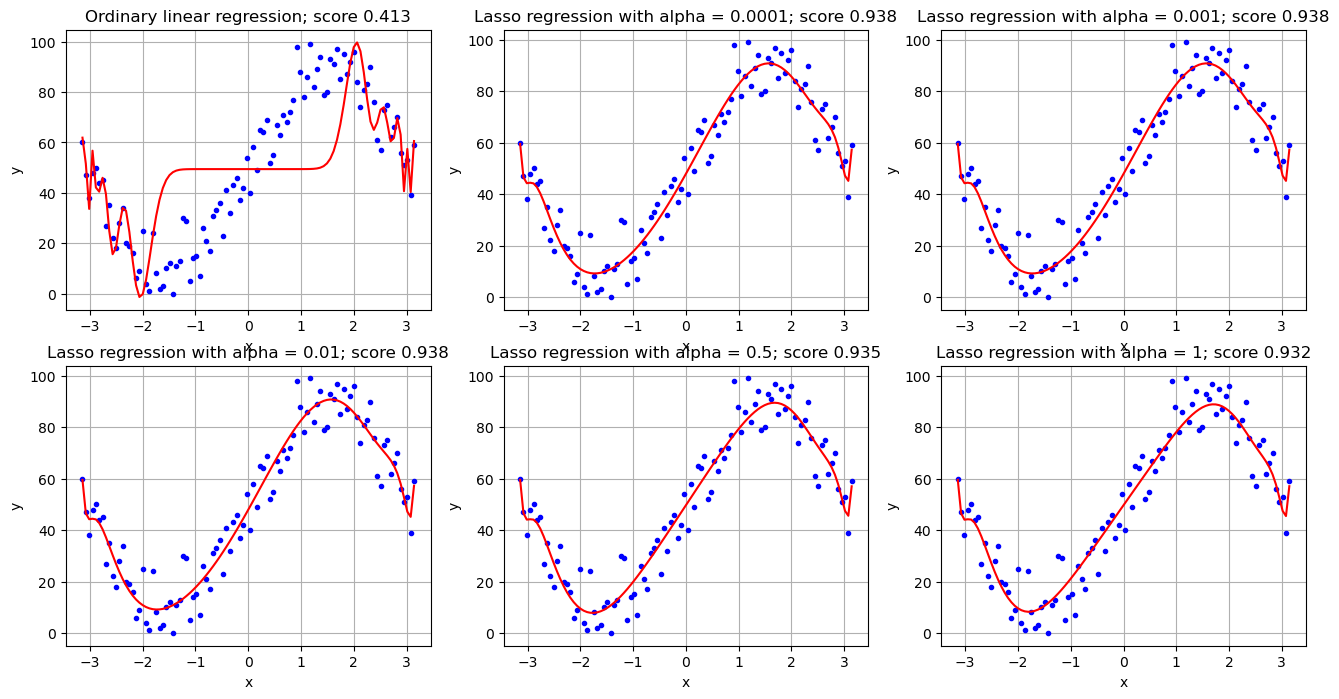

In [21]:
from sklearn.linear_model import Lasso

alphas = [0, 0.0001, 0.001, 0.01, 0.5, 1]
fig = plt.figure(figsize=(16, 8))

weights = {}
for i, a in enumerate(alphas):
    poly = PolynomialFeatures(degree=40, include_bias=False)

    
    poly_features = poly.fit_transform(X)

    model = LinearRegression() if a == 0 else Lasso(alpha=a)
    model.fit(poly_features, y)
    
    weights[f"alpha = {a}"] = model.coef_
        
    plt.subplot(2, 3, i + 1)
    plt.plot(X, y, "b.")

    plt.plot(X, model.predict(poly_features), 'r-')
    plt.xlabel('x')
    plt.ylabel('y')
    if a == 0:
        plt.title(f"Ordinary linear regression; score {model.score(poly_features, y):.3f}")
    else:
        plt.title(f"Lasso regression with alpha = {a}; score {model.score(poly_features, y):.3f}")
    
    plt.grid()

The above code can be simplified with pipelines like this:

/Users/aalgahmi/opt/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+03, tolerance: 8.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/aalgahmi/opt/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e+03, tolerance: 8.332e+00
  model = cd_fast.enet_coordinate_descent(
/Users/aalgahmi/opt/miniconda3/envs/dl/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

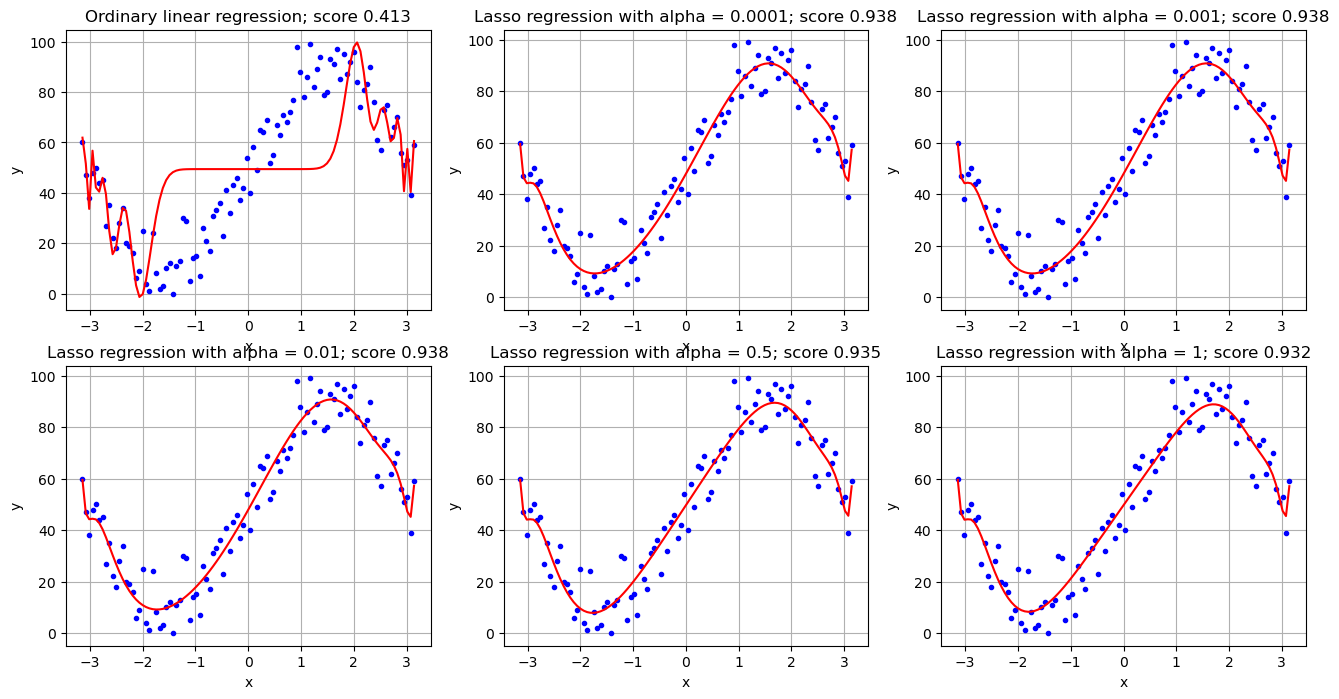

In [22]:
alphas = [0, 0.0001, 0.001, 0.01, 0.5, 1]
fig = plt.figure(figsize=(16, 8))

weights = {}
for i, a in enumerate(alphas):
    model = make_pipeline(PolynomialFeatures(degree=40, include_bias=False), 
                          LinearRegression() if a == 0 else Lasso(alpha=a)).fit(X, y)
    
    weights[f"alpha = {a}"] = model[-1].coef_
        
    plt.subplot(2, 3, i + 1)
    plt.plot(X, y, "b.")

    plt.plot(X, model.predict(X), 'r-')
    plt.xlabel('x')
    plt.ylabel('y')
    if a == 0:
        plt.title(f"Ordinary linear regression; score {model.score(X, y):.3f}")
    else:
        plt.title(f"Lasso regression with alpha = {a}; score {model.score(X, y):.3f}")
    
    plt.grid()

As you can see, even a small amount of regularization has a large impact on overfitting. See the two top-left plots. But just like with everything, too much of a good thing is not good. Let's display the learned weights of these models: 

In [23]:
pd.DataFrame(weights).round(6)

,alpha = 0,alpha = 0.0001,alpha = 0.001,alpha = 0.01,alpha = 0.5,alpha = 1
0,0.000148,36.870716,36.860390,36.757128,31.135384,29.212310
1,0.000020,3.433421,3.425791,3.349147,0.000000,0.000000
2,-0.000014,-4.196158,-4.189942,-4.127784,-0.743712,0.000000
3,0.000002,-1.178064,-1.175408,-1.148697,0.000049,0.000000
4,0.000197,-0.132267,-0.133227,-0.142831,-0.665774,-0.718143
5,-0.000000,0.049307,0.049045,0.046415,-0.064527,-0.067462
6,-0.000002,0.006846,0.006862,0.007025,0.015941,0.008830
7,0.000000,0.007180,0.007180,0.007184,0.006923,0.007187
8,0.000020,0.000939,0.000941,0.000966,0.002303,0.002772
9,-0.000000,0.000482,0.000482,0.000484,0.000599,0.000634


You can see that most of the weights of the lasso models are zeros. This is an example of the **feature selection** of lasso regression.

## Logistic regression

We can write $h(\mathbf{X})$ as:

$$ h(\mathbf{X}) = g(\mathbf{X} \mathbf{w}) = g(z)$$

For linear regression:
$$ g(z) = z $$

and for logistic regression:
$$ g(z) = \frac{1}{1 + e^{-z}} $$

where $g$ is the **logistic** or **sigmoid** function, which is defined as:

$$ h(\mathbf{X}) = \frac{1}{1 + e^{- \mathbf{X} \mathbf{w}}} $$

This means that $h(\mathbf{X}) \in [0, 1]$, which means that it can be interpreted as a probability:
 
 
$$ p(y | \mathbf{x}; \mathbf{w}) = {\begin{cases}h(\mathbf{x})& {\text{ if }}y = 1\\1 - h(\mathbf{x})&{\text{ if }} y = 0\end{cases}} $$

which can be written as:
$$ p(y | \mathbf{x}; \mathbf{w}) = h(\mathbf{x})^y (1 - h(\mathbf{x}))^{1 - y} $$

In addition, given the sigmoid function $$ g(z) = \frac{1}{1 + e^{-z}}$$
    
it can be shown that:

$$g'(z) = \frac{d}{dz} \frac{1}{1 + e^{-z}} = g(z) (1 - g(z))$$

In [24]:
class LogisticRegression:
    def __init__(self, eta=.0001, epochs=100, random_state=17):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = np.concatenate(
            (np.ones((len(X), 1)), X.reshape(len(X), -1) if X.ndim == 1 else X), axis=1)
        y = y.reshape(len(X), -1) if y.ndim == 1 else y
        n = X.shape[0]
        m = X.shape[1]
        rgen = np.random.RandomState(self.random_state)
        self.w = rgen.normal(loc=0.0, scale=0.01, size=m).reshape(m, 1)
        for i in range(self.epochs): 
            z = np.dot(X, self.w)
            h = self.sigmoid(z)
            self.w = self.w + self.eta * np.dot(X.T, (y - h))
        
        return self
    
    def predict_proba(self, X_unseen):
        Z = np.dot(np.concatenate([np.ones((len(X_unseen), 1)), X_unseen], axis=1), self.w).squeeze()
        return 1 / (1 + np.exp(-Z))
            
    def predict(self, X_unseen, threshold=.5):
        p = self.predict_proba(X_unseen)
        return np.where(p <= 0.5, 0, 1)

To see how this logistic classifier works, let's generate some data.

### Example 1: one-dimensional data
We start by generating one-dimensional data with two classes (0 and 1).

In [25]:
n = 300
data = np.array([[3, 14],[10, 9]])

# Group A: data with class 0
d0 = np.concatenate((data[0, 1] + np.random.normal(loc=1, scale=1.3, size=(n, 1)), 
                     np.zeros(n).reshape(n, 1)), axis= 1)
# Group B: data with class 1
d1 = np.concatenate((data[1, 1] + np.random.normal(loc=.5, scale=1.3, size=(n, 1)), 
                     np.ones(n).reshape(n, 1)), axis= 1)

# Combining both sets into one dataset
d = np.concatenate((d0, d1), axis=0)
data = pd.DataFrame(d, columns=['x', 'y'])

Let's plot this data:

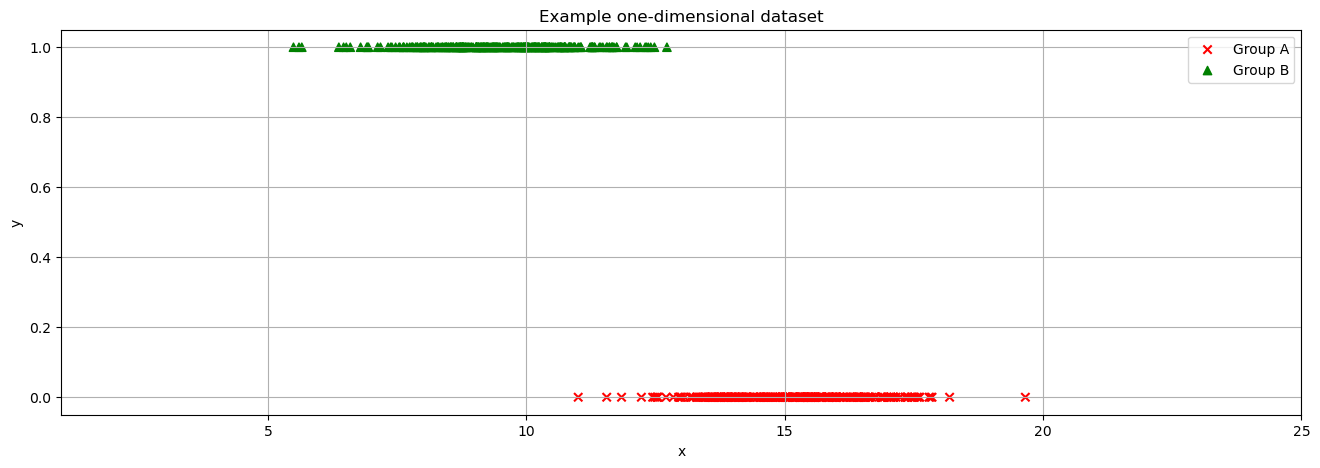

In [26]:
def color_by_label(ds):
    return list(map(lambda y: 'r' if y == 0 else 'g', ds))

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)

a_ = data[data['y'] == 0]
ax.scatter(a_.iloc[:, 0], a_.iloc[:, 1], c=color_by_label(a_['y'].to_list()), marker='x', label='Group A')

b_ = data[data['y'] == 1]
ax.scatter(b_.iloc[:, 0], b_.iloc[:, 1], c=color_by_label(b_['y'].to_list()), marker='^', label='Group B')

ax.set_xlim(1,25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Example one-dimensional dataset')
ax.legend(loc='best')
ax.grid()

We have a few hyper parameters to consider. So let's spit this dataset into test, validation, and training.

In [27]:
x, y, features, target = my.from_dataframe(data)

X_rest, X_test, y_rest, y_test = my.train_test_split(x, y, test_size=0.20)
X_train, X_valid, y_train, y_valid = my.train_test_split(X_rest, y_rest, test_size=0.20)

We now train a logistic regression classifier:

In [28]:
logr = LogisticRegression().fit(X_train, y_train)
print(logr.w)

[[ 0.40441681]
 [-0.0582853 ]]


Let's test it:

In [29]:
cm = my.confusion_matrix(y_train, logr.predict(X_train))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(y_test, logr.predict(X_test))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

[[182   0]
 [196   6]]
Training accuracy:  0.4895833333333333
[[63  0]
 [54  3]]
Test accuracy:  0.55


which is not good. Can we improve it? Let's see if increasing the number of epochs helps. We'll use the validation dataset here to determine a good value for `epochs`.

Text(0.5, 1.0, 'Logistic regression learning curves - using epochs')

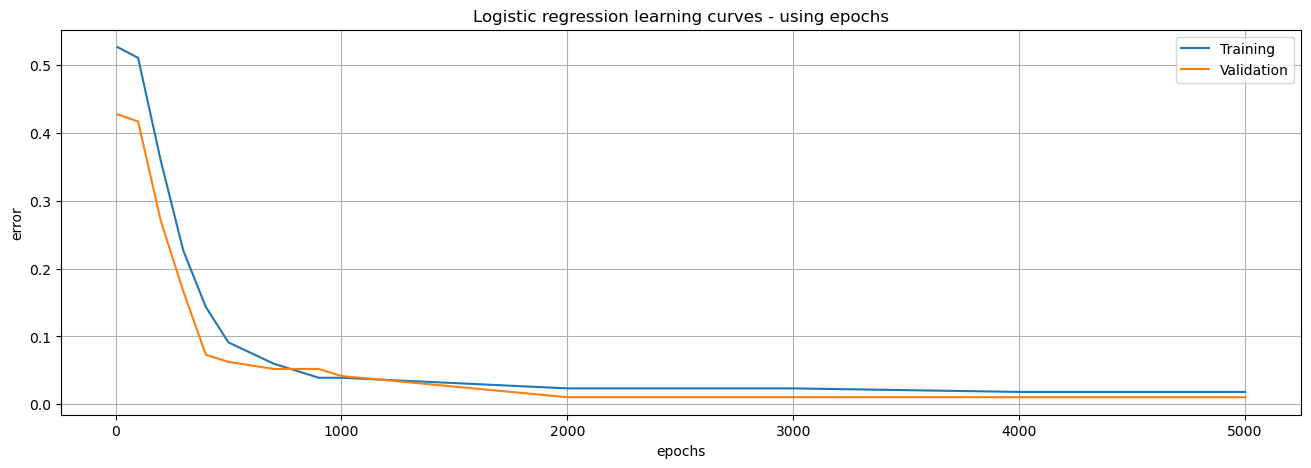

In [30]:
epochs = [10, 100, 200, 300, 400, 500, 700, 900, 1000, 2000, 3000, 4000, 5000]
train_err = []
valid_err = []
for n in epochs:
    logr = LogisticRegression(epochs=n).fit(X_train, y_train)
    
    cm = my.confusion_matrix(y_train, logr.predict(X_train))
    train_err.append(1 - np.trace(cm) / np.sum(cm))

    cm = my.confusion_matrix(y_valid, logr.predict(X_valid))
    valid_err.append(1 - np.trace(cm) / np.sum(cm))
 
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(epochs, train_err, label="Training")
ax.plot(epochs, valid_err, label="Validation")
ax.set_xlabel("epochs")
ax.set_ylabel("error")
ax.legend()
ax.grid()
ax.set_title("Logistic regression learning curves - using epochs")

From the plot above, an `epochs` value around `3000` (which can change from one run to another) seems reasonable. Let's test with it:

In [31]:
logr = LogisticRegression(epochs=3000).fit(X_train, y_train)

cm = my.confusion_matrix(y_test, logr.predict(X_test))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

[[62  1]
 [ 1 56]]
Test accuracy:  0.9833333333333333


which is much much better. 

Here is a plot of the above data with the logistic (sigmoid) function imposed on it to show you how logistic regression works. Can you spot the misclassified examples?

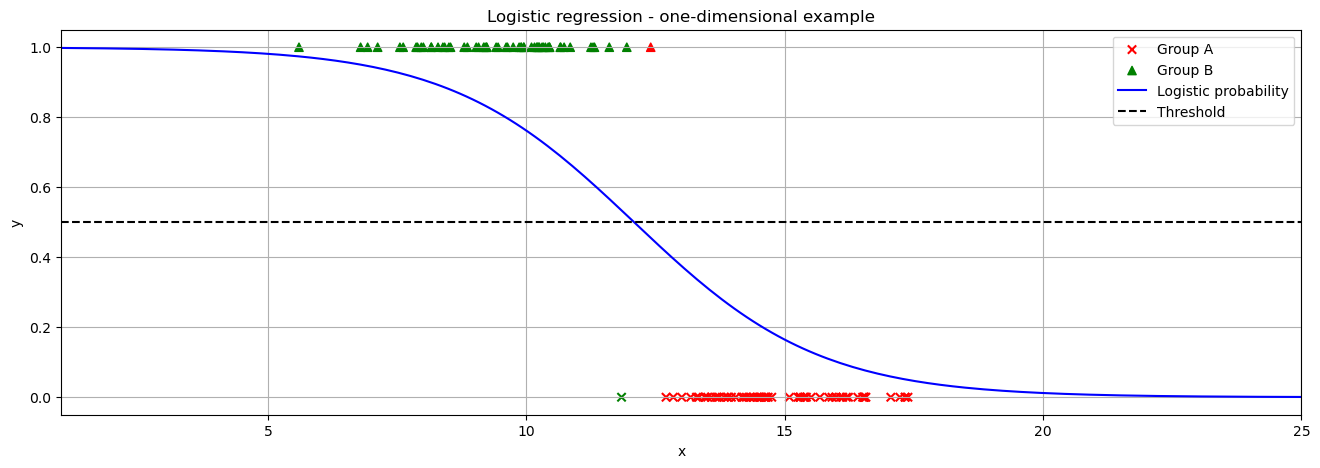

In [32]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)

test = my.to_dataframe(X_test, y_test)
a_ = test[test['y'] == 0]
# print(a_.iloc[:,:-1].to_numpy())
predicted = logr.predict(a_.iloc[:,:-1].to_numpy())
ax.scatter(a_.iloc[:, 0], a_.iloc[:, 1], c=color_by_label(predicted), marker='x', label='Group A')

b_ = test[test['y'] == 1]
predicted = logr.predict(b_.iloc[:,:-1].to_numpy())
ax.scatter(b_.iloc[:, 0], b_.iloc[:, 1], c=color_by_label(predicted), marker='^', label='Group B')

# plotting the logistic (sigmoid) function
x = np.linspace(1, 25, 200).reshape(200, 1)
p = logr.predict_proba(x)
ax.plot(x, p, color='blue', label='Logistic probability')

ax.plot([1, 25], [.5, .5], linestyle='dashed', color='k', label='Threshold')

ax.set_xlim(1,25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Logistic regression - one-dimensional example')
ax.legend(loc='best')
ax.grid()

### Example 2: two-dimensional data

We now generate two-dimensional data with two features ($x_1$, $x_2$) and an output column with two classes (0, 1):

In [33]:
n = 150
data = np.array([[3, 14],[10, 9]])
d0 = np.concatenate((data[0,0] + np.random.normal(loc=1, scale=2.8, size=(n, 1)), 
                data[0, 1] + np.random.normal(loc=1, scale=1.2, size=(n, 1)), np.zeros(n).reshape(n, 1)), axis= 1)

d1 = np.concatenate((data[1,0] + np.random.normal(loc=.5, scale=2.5, size=(n, 1)), 
                data[1, 1] + np.random.normal(loc=.5, scale=1, size=(n, 1)), np.ones(n).reshape(n, 1)), axis= 1)


d = np.concatenate((d0, d1), axis=0)
data = pd.DataFrame(d, columns=['x1', 'x2', 'y'])

Here is how the generated data looks like:

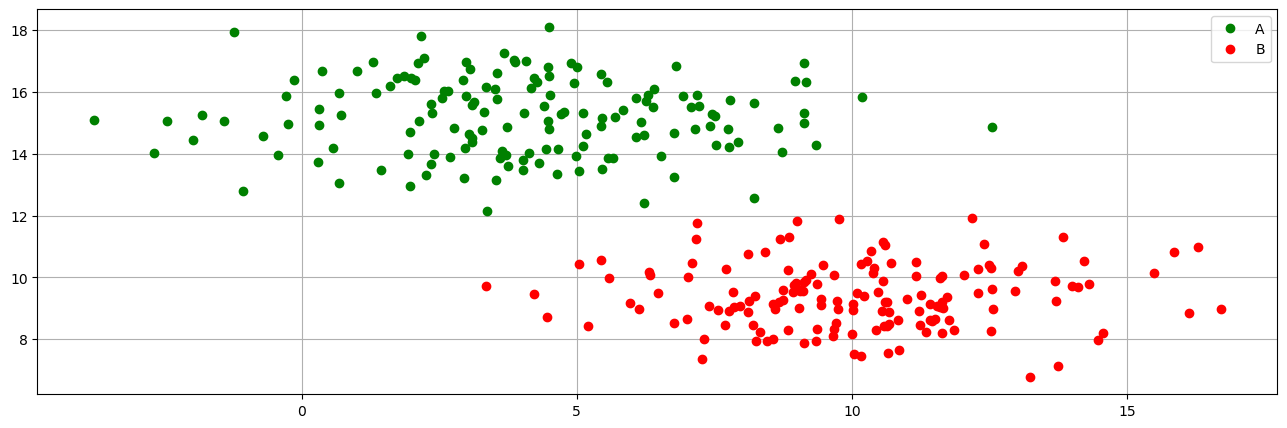

In [34]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
a_ = data[data['y'] == 0].iloc[:, :-1].values
ax.plot(a_[:, 0], a_[:, 1], 'go', label='A')

b_ = data[data['y'] == 1].iloc[:, :-1].values
ax.plot(b_[:, 0], b_[:, 1], 'ro', label='B')

ax.grid()
ax.legend(loc='best')

We now split this data into training and test sets.

In [35]:
X, y, features, target = my.from_dataframe(data)
X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size=0.33)

We train our logistic regression classifier and display the learned weights.

In [36]:
logr = LogisticRegression().fit(X, y)
print(logr.w)

[[ 0.0588837 ]
 [ 0.75191629]
 [-0.46905793]]


which gives us the following confusion matrix and accuracy:

In [37]:
cm = my.confusion_matrix(y_train, logr.predict(X_train))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[100   5]
 [  6  90]]
Training accuracy:  0.945273631840796


Here is the corresponding decision regions plot:

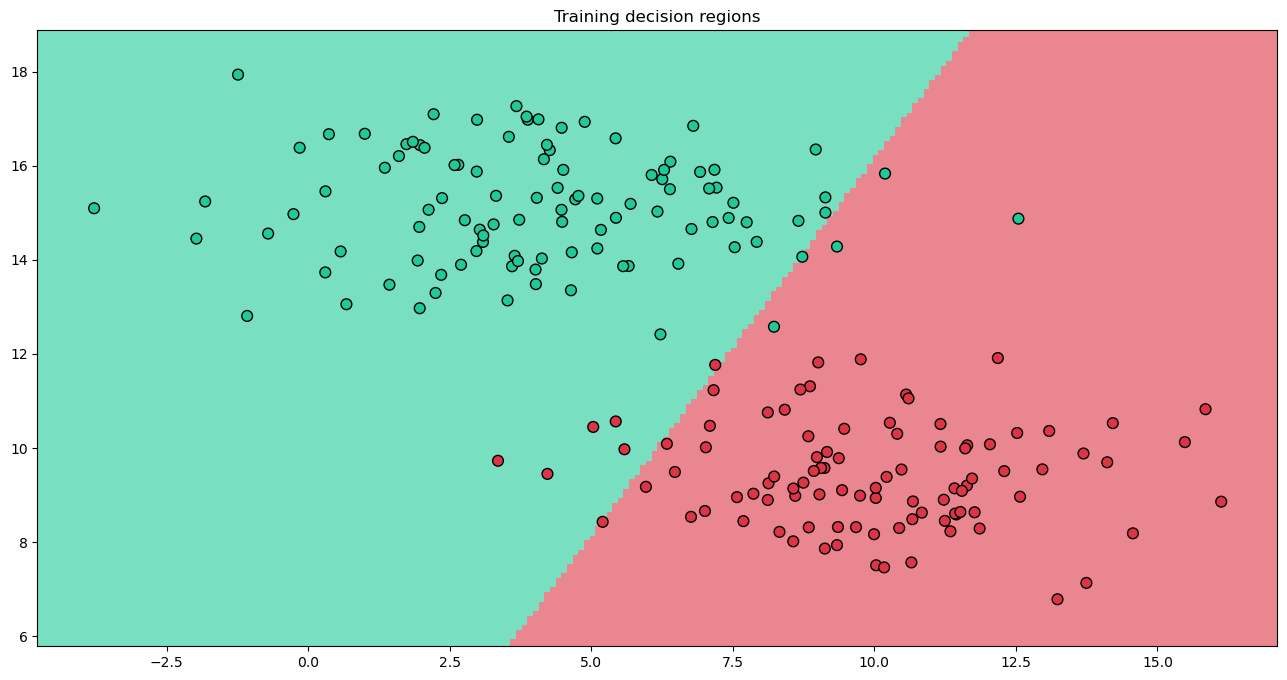

In [38]:
my.plot_decision_regions(X_train, y_train, logr, resolution=0.1, title="Training decision regions")

Let's now test our trained logistic model:

[[45  0]
 [ 1 53]]
Test accuracy:  0.98989898989899


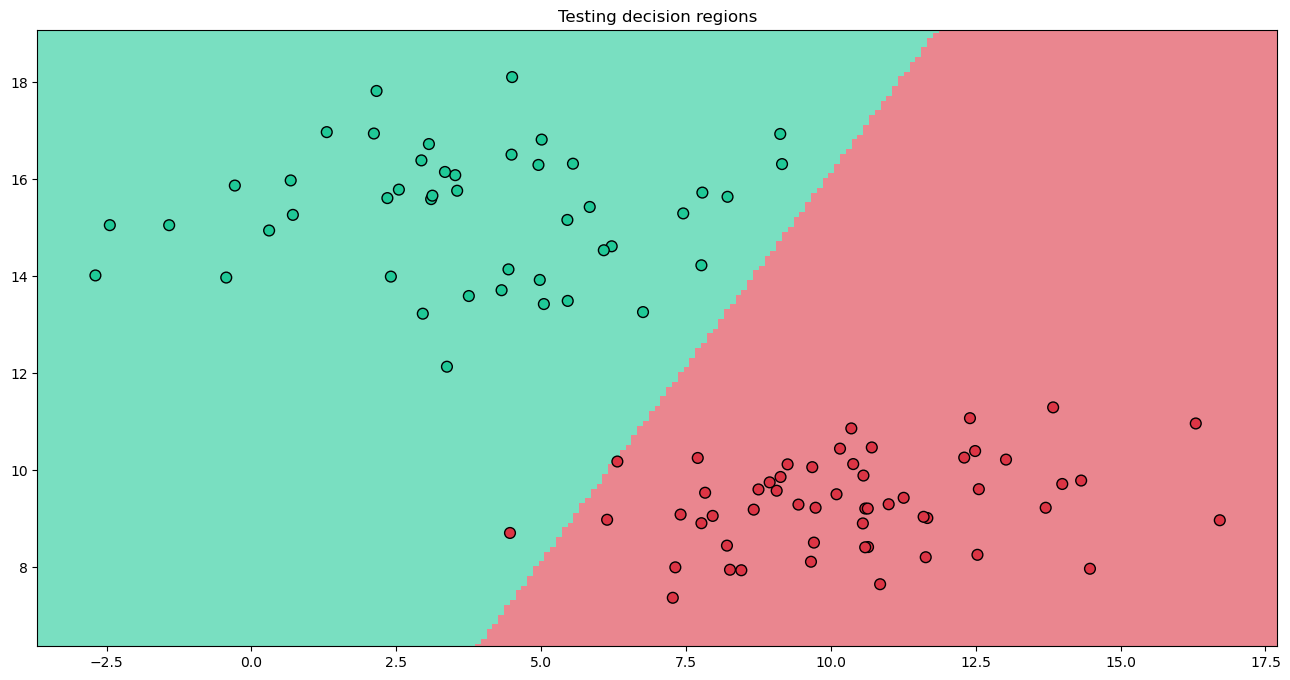

In [39]:
cm = my.confusion_matrix(y_test, logr.predict(X_test, threshold=.5))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

my.plot_decision_regions(X_test, y_test, logr, resolution=0.1, title="Testing decision regions")

### Example 3: using SciKit Learn

Most machine learning problems require passing the data through a series of transformation steps (such as scaling, on-hot encoding, etc) before it is used to train an estimator. Instead of doing these steps manually one at a time, Scikit learn allows us to streamline them using pipelines. A pipeline is a set of transforming tasks followed by an estimator.

As a final example, we'll download the [Wisconsin Breast Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+\(diagnostic\)). This data set has 30 numeric input features (columns 2 to 31) and an output column (#1) with two classes: B for benign and M for malignant.

In [40]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
    header=None)
X, y = df.iloc[:, 2:].values, df.iloc[:, 1].values

my.to_dataframe(X, y)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,M
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,M
2,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,...,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,M
4,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,...,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,0.1726,0.05623,...,26.4,166.1,2027.0,0.141,0.2113,0.4107,0.2216,0.206,0.07115,M
565,20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,0.1752,0.05533,...,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637,M
566,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,0.159,0.05648,...,34.12,126.7,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782,M
567,20.6,29.33,140.1,1265.0,0.1178,0.277,0.3514,0.152,0.2397,0.07016,...,39.42,184.6,1821.0,0.165,0.8681,0.9387,0.265,0.4087,0.124,M


We also need to change the output classes to numeric values. We can use `LabelEncoder` to do that.

In [41]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

Here is what the encoded classes or labels are and what the transformed output column looks like:

In [42]:
encoder.classes_, y

(array(['B', 'M'], dtype=object),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
    

This means `B` is mapped to `0` and `M` to `1`.

Next we need to scale the input features before we train a logistic regression model. We will use a pipeline for this instead of doing these steps individually.

In [43]:
from sklearn.linear_model import LogisticRegression
pipeline = make_pipeline(StandardScaler(),
                         LogisticRegression())

We now split the dataset:

In [44]:
X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size=0.20, random_state=1)

and train the model:

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Let's also test it:

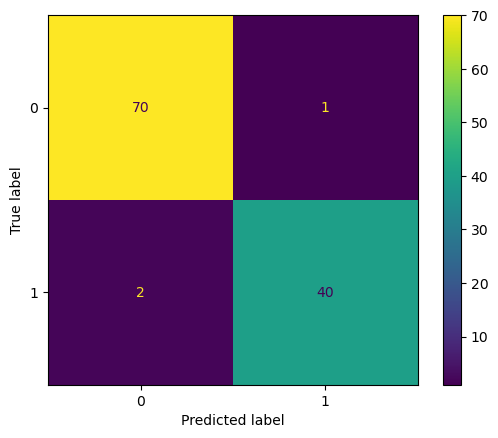

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

We can also display various metrics such as accuracy, recall, precision, and f1-score using the `classification_report` function.

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pipeline.predict(X_test), target_names=encoder.classes_))

              precision    recall  f1-score   support

           B       0.97      0.99      0.98        71
           M       0.98      0.95      0.96        42

    accuracy                           0.97       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



Finally let's show the ROC plot and calculate the AUC (Area Under the Curve) which is another metric of performance.

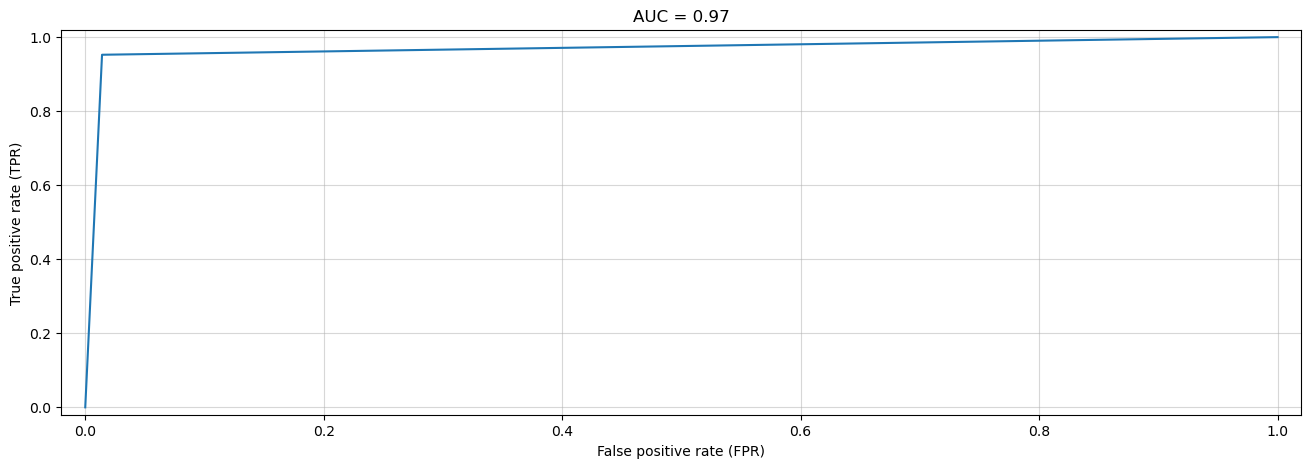

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(16, 5))
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=pipeline.predict(X_test))
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title(f"AUC = {roc_auc:.2f}")
plt.show()

## Exercise

Do Exercise 4